In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
frames = glob.glob('pets/*.jpg')


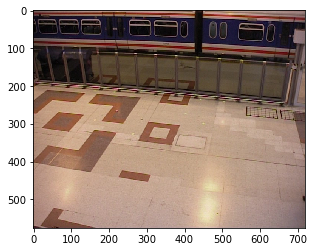

In [3]:
a=plt.imread(frames[1])
plt.imshow(a)

In [4]:
frame = plt.imread(frames[0])
frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])


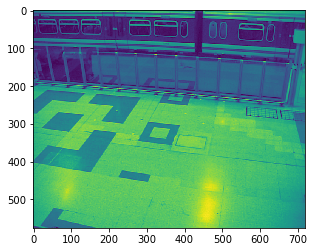

In [5]:
plt.imshow(frame)


In [6]:
np.min(frame)


0.0

In [7]:
shape = frame.shape

In [8]:
shape

(576, 720)

In [9]:
type(frame)

numpy.ndarray

In [10]:
frame

array([[ 85.176,  65.937,  64.937, ..., 104.841, 104.83 , 106.83 ],
       [ 94.116,  75.176,  74.948, ...,  99.83 , 100.058, 100.058],
       [103.643,  85.888,  87.176, ..., 109.058, 108.699, 109.699],
       ...,
       [ 53.97 ,  39.921,  41.22 , ..., 101.05 , 100.039, 103.039],
       [ 50.127,  38.665,  45.263, ...,  96.05 ,  99.039, 105.039],
       [ 10.871,   8.714,  10.85 , ...,   2.381,  10.039,  20.039]])

In [11]:
K=4

In [12]:
#out = cv2.VideoWriter('outhighway.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (shape[0],shape[1]))
parameters = np.zeros((shape[0],shape[1],K*2 + K))
alpha = 0.001 #To update weight 
#K gaussians, 1 parameter for sigma, 1 for mu for each of the gaussians and 4 parameters for the weights

In [13]:
import numpy.matlib as nlib
parameters[:,:,8:12]=1/K #Setting initial weights
frame = frame/255.0 #Normalise 1st frame
parameters[:,:,0]=0.0784#20#Standard deviation is one
parameters[:,:,2]=0.0784#20
parameters[:,:,4]=0.0784#20
parameters[:,:,6]=0.0784#20#Standard deviation is one for first frame
frame = plt.imread(frames[5])
parameters[:,:,1]=np.dot(frame[...,:3], [0.299, 0.587, 0.114])/255.0#0.62745#frame#Mean value is just pixel value for first frame
frame = plt.imread(frames[6])
parameters[:,:,3]=np.dot(frame[...,:3], [0.299, 0.587, 0.114])/255.0#0.18#frame
frame = plt.imread(frames[7])
parameters[:,:,5]=np.dot(frame[...,:3], [0.299, 0.587, 0.114])/255.0#0.144#frame
frame = plt.imread(frames[8])
parameters[:,:,7]=np.dot(frame[...,:3], [0.299, 0.587, 0.114])/255.0#0.5806274509803921#frame

In [14]:
#Gaussian function
def Gaussian(mu,sigmasquare,x):
    #mu and x are 1*1
    #a = np.transpose(x-mu)
    #siginv = (1/sigmasquare)*np.array([[1,0,0],[0,1,0],[0,0,1]])
    #b = np.matmul(a,siginv)
    #b = np.matmul(b,x-mu)
    b = (x-mu)*(x-mu)
    b = b*(-1/2)
    b = b/sigmasquare
    b = np.exp(b)
    b = b/np.power(2*22/7,0.5)
    sigma = np.sqrt(sigmasquare)
    b = b/(sigma)
    fg=0
    if(x>mu+2.5*sigma):
        fg=1
    if(x<mu-2.5*sigma):
        fg=1
    b = alpha*b
    return b,fg

In [15]:
#out.release()


In [18]:
#Parameter updation and backgroud detection using rest of the frames
def processframes(k):
    #Parameter updation and backgroud detection using rest of the frames
    #while(ret==True):
    l=k+10
    while(k<=l):
        frame = plt.imread(frames[k])
        frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
        frame = frame/255.0
        k=k+1
        foreground = np.zeros((shape[0],shape[1],3))#Full black
        print(k)
        for i in range(shape[0]):
            for j in range(shape[1]):
                #Getting details of current frame with past parameters
                ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
                ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
                ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
                ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
                prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
                prob = prob/alpha
                if(prob>0.5):
                    foreground[i,j,:]=1
                #Updating weights
                if(fg1>=2):
                    parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
                else:
                    parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
                if(fg2>=2):
                    parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
                else:
                    parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
                if(fg3>=2):
                    parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
                else:
                    parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
                if(fg4>=2):
                    parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
                else:
                    parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
                #Updating mu
                parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
                parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
                parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
                parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
                #Updating sigma
                parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
                parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
                parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
                parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])

    plt.imsave(str(k)+'.png',foreground.astype(np.float))
                # Write the frame into the file 'outhighway.avi'
                #foreground = foreground.astype(np.uint8)
                #out.write(foreground)
    return(k)
            

In [ ]:
k=processframes(9)#25
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#
k=processframes(k)#

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
